# Experiment Evaluation
Look at experiment results, compare them and find representative examples for the thesis motivation.

In [26]:
import os
from glob import glob
import yaml
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp

from enhancing_sgmcmc.utils import run_experiment, plot_gmm_sampling

In [2]:
os.chdir("..")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def load_experiment_data(experiment_name) -> pd.DataFrame:
    """
    Load experiment data from YAML files.
    """
    path = f"results\\{experiment_name}\\**\\"
    files = glob(path + "*.yaml", recursive=True)

    df = pd.DataFrame()
    for file in files:
        df_temp = yaml.load(open(file), Loader=yaml.FullLoader)
        df_temp = pd.json_normalize(df_temp, sep="_")
        df_temp["file"] = file.split("/")[-1]
        df = pd.concat([df, df_temp], ignore_index=True)

    return df.rename(columns=lambda x: x.replace("parameters_", "").replace("results_metrics_", ""))


def plot_experiment_data(df: pd.DataFrame, experiment_name: str) -> None:
    return NotImplementedError

In [5]:
# set this to Fals to save some runtime and skip generating computational heavy plots
run_sampling = True

## Unimodal Example
### Load Experiment Results

In [6]:
experiment_name = "unimodal_gaussian"
df = load_experiment_data(experiment_name)

## Hyperparameter Analysis

We tried out different values for step size and momentum decay to make sure finding optimal values for those both HPs for each given setting. It is hard to derive the effectiveness of sampling from the used metrics (wasserstein, nll) since they are quite generic and break down the problem to just one scalar. Since we are drawing quite many samples compared to the relatively simple true posterior it might be not clear which configuration works best. <br>
We choose to do visual inspection to check if there is a reasonable exploration exploitation tradeoff.

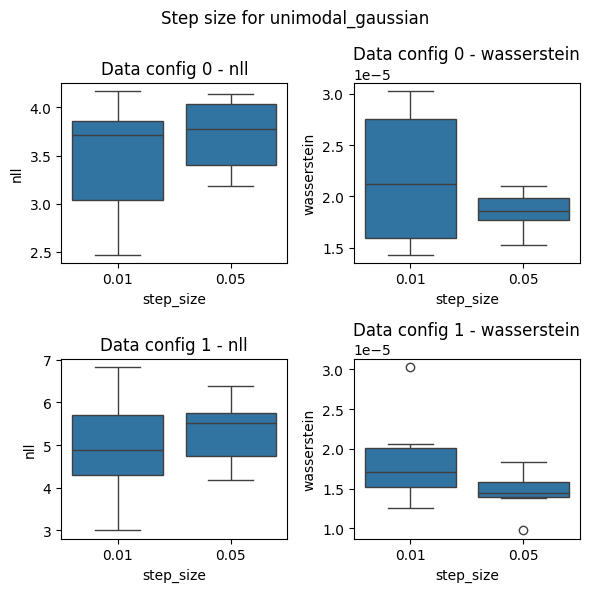

In [7]:
metrics = ["nll", "wasserstein"]
param = "step_size"

fig, axs = plt.subplots(max(df["data_config_id"]) + 1, 2, figsize=(6, 6))
fig.suptitle(f"Step size for {experiment_name}")
for data_idx in df["data_config_id"].unique():
    for i, metric in enumerate(metrics):
        # filter dataframe for the current data_config_id and metric
        df_temp = df[df["data_config_id"] == data_idx]

        # only evaluate if preconditioning was the identity matrix
        df_temp = df_temp[df_temp["init_m"].apply(lambda x: x == [1.0, 1.0])]

        sns.boxplot(data=df_temp, x=param, y=metric, ax=axs[data_idx, i])
        axs[data_idx, i].set_title(f"Data config {data_idx} - {metric}")

plt.tight_layout()
plt.savefig(f"thesis/figures/{experiment_name}_step_size.png", dpi=300, bbox_inches="tight")

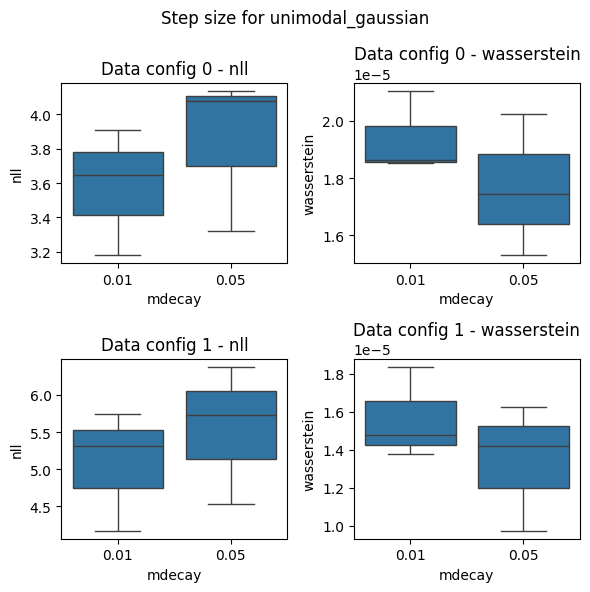

In [8]:
param = "mdecay"

fig, axs = plt.subplots(max(df["data_config_id"]) + 1, 2, figsize=(6, 6))
fig.suptitle(f"Step size for {experiment_name}")
for data_idx in df["data_config_id"].unique():
    for i, metric in enumerate(metrics):
        df_temp = df[df["data_config_id"] == data_idx]

        # filter to only one distinct step size
        df_temp = df_temp[df_temp["step_size"] == 0.05]

        df_temp = df_temp[df_temp["init_m"].apply(lambda x: x == [1.0, 1.0])]

        sns.boxplot(data=df_temp, x=param, y=metric, ax=axs[data_idx, i])
        axs[data_idx, i].set_title(f"Data config {data_idx} - {metric}")

plt.tight_layout()
plt.savefig(f"thesis/figures/{experiment_name}_mdecay.png", dpi=300, bbox_inches="tight")

The HPs have a interaction effect. For a larger step size (e.g. 0.05) a higher mdecay yields better metrics (lower wasserstein distance and higher nll). While a smaller step size also requires a smaller mdecay. The overall metrics are better for the larger values, since they allow more exploration of the space. We also can see this effects when looking at the sampling trajectory through plots.

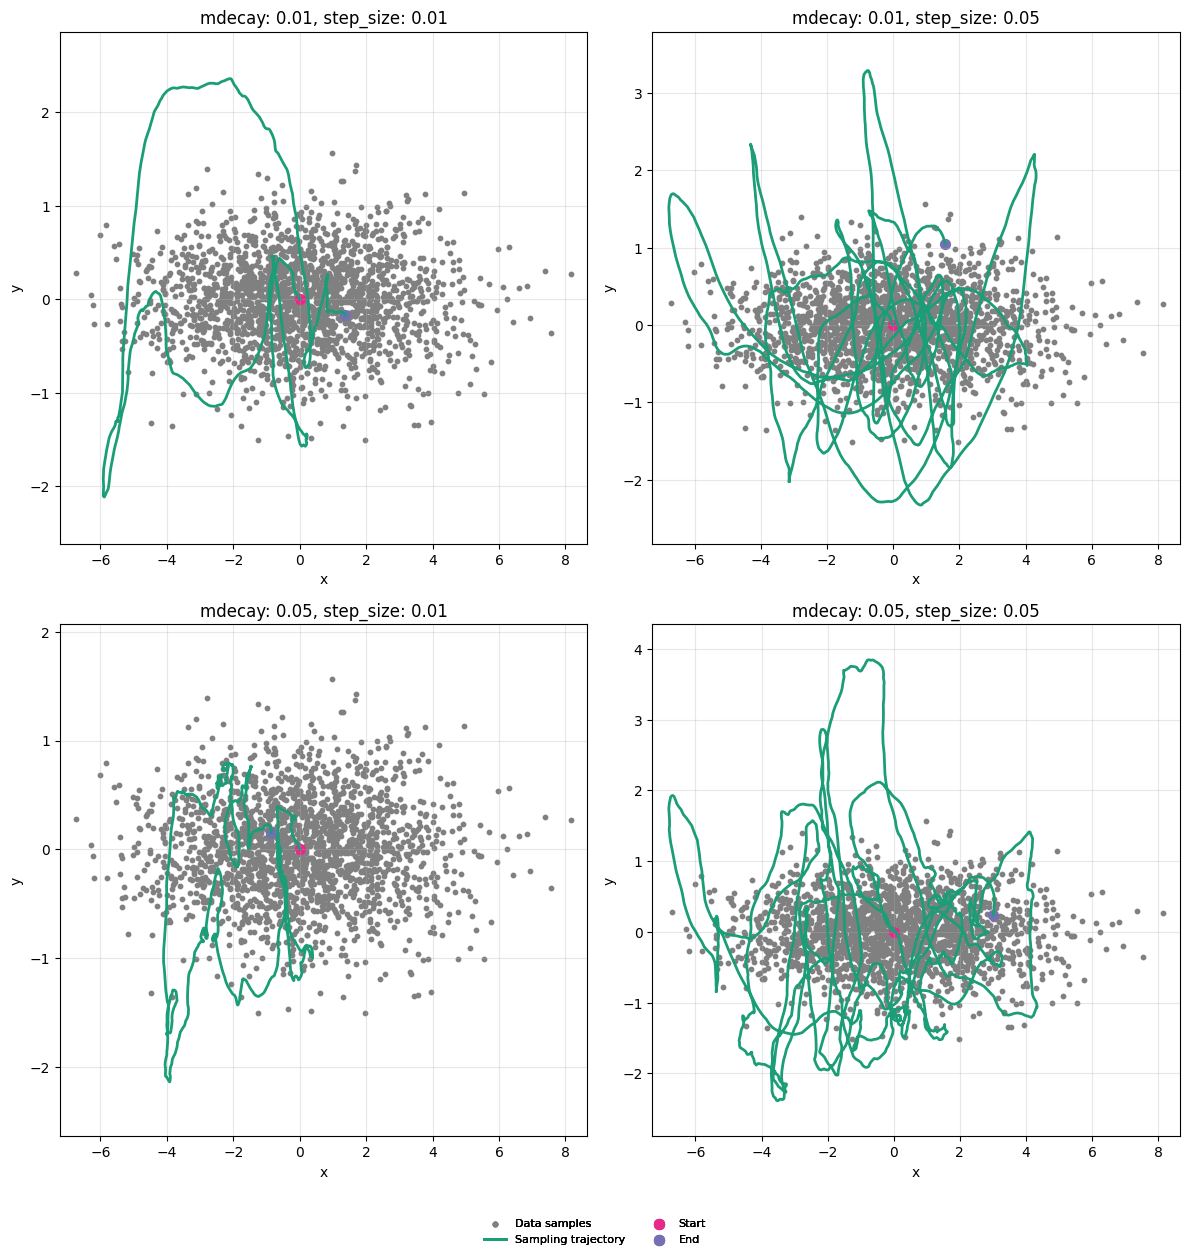

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

param_grid = list(
    product(
        [0.01, 0.05],
        [0.01, 0.05],
    )
)

axs_flat = axs.flatten()

for i, (mdecay, step_size) in enumerate(param_grid):
    data, trajectory = run_experiment(
        means=jnp.array([[0.0, 0.0]]),
        covs=jnp.array([[[5.0, 0.0], [0.0, 0.2]]]),
        weights=jnp.array([1.0]),
        data_samples=2000,
        mcmc_samples=2000,
        init_position=jnp.array([0.0, 0.0]),
        init_m="identity",
        mdecay=mdecay,
        step_size=step_size,
        n_batches=5,
        seed=1,
    )

    plot_gmm_sampling(
        fig=fig,
        ax=axs[i // 2, i % 2],
        trajectory=trajectory,
        samples=data,
        means=jnp.array([[0.0, 0.0]]),
        covs=jnp.array([[[5.0, 0.0], [0.0, 0.2]]]),
        weights=jnp.array([1.0]),
        title=f"mdecay: {mdecay}, step_size: {step_size}",
        plot_type="sampling",
    )

# Adjust layout
plt.tight_layout()
plt.show()

### Effect of preconditioning

In [ ]:
# TODO: show with metrics and plots why preconditioning is helpful in the skewed case

## Gaussian Mixture

 By not only testing the sampler on a single mode we can get a better understanding of its behavior in a more complex posterior distribution.

### Load data

In [ ]:
experiment_name = "mixture_gaussian"
df = load_experiment_data(experiment_name)

In [ ]:
# TODO: can we really use the computed metrics here? what do they tell us?